# Case Study: Demand forecasting
# Context: Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.
# The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:
# Historical data of demand for a product-center combination (Weeks: 1 to 145)
# Product(Meal) features such as category, sub-category, current price and discount
# Information for fulfillment center like center area, city information etc.

## Content:
## Weekly Demand data (train.csv): Contains the historical demand data for all centers
## fulfilment_center_info.csv: Contains information for each fulfillment center
## meal_info.csv: Contains information for each meal being served.

# Import the Relevant libraries and Packages

In [209]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyoff
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from xgboost import XGBRegressor
from xgboost import plot_importance

from warnings import simplefilter

# Load the Dataset into dataframe

In [210]:
df_fulfil_data = pd.read_csv(r'C:\Users\kgupta\Desktop\Product_Demand_Data\fulfilment_center_info.csv')
df_meal_data = pd.read_csv(r'C:\Users\kgupta\Desktop\Product_Demand_Data\meal_info.csv')
df_train_data = pd.read_csv(r'C:\Users\kgupta\Desktop\Product_Demand_Data\train.csv')
df_test_data = pd.read_csv(r'C:\Users\kgupta\Desktop\Product_Demand_Data\test.csv')

In [211]:
df_train_data.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [212]:
# Check the Rows and columns
print('The rows and columns of Fulfilment_data:', format(df_fulfil_data.shape))
print('The rows and columns of Meal_data:', format(df_meal_data.shape))
print('The rows and columns of Training_data:', format(df_train_data.shape))
print('The rows and columns of Testing_data:', format(df_test_data.shape))

The rows and columns of Fulfilment_data: (77, 5)
The rows and columns of Meal_data: (51, 3)
The rows and columns of Training_data: (456548, 9)
The rows and columns of Testing_data: (32573, 8)


# Merge the Meal and Fulfillment Information into the training data

In [213]:
merge1 = pd.merge(df_train_data, df_fulfil_data, how = "inner",on='center_id')
df = pd.merge(merge1, df_meal_data, how = "inner",on='meal_id')

In [214]:
df.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


# Check the null values from dataframe

In [215]:
df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

# Check duplicated data

In [216]:
df.duplicated().sum()

0

# Study the columns and their relationship

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

In [218]:
# CHeck the cuisine which is popular
data = df['cuisine'].value_counts(normalize = True) * 100

In [219]:
# Reset the Index 
data = data.reset_index()

In [220]:
data.rename(columns = {'proportion': 'Percentage'}, inplace = True)

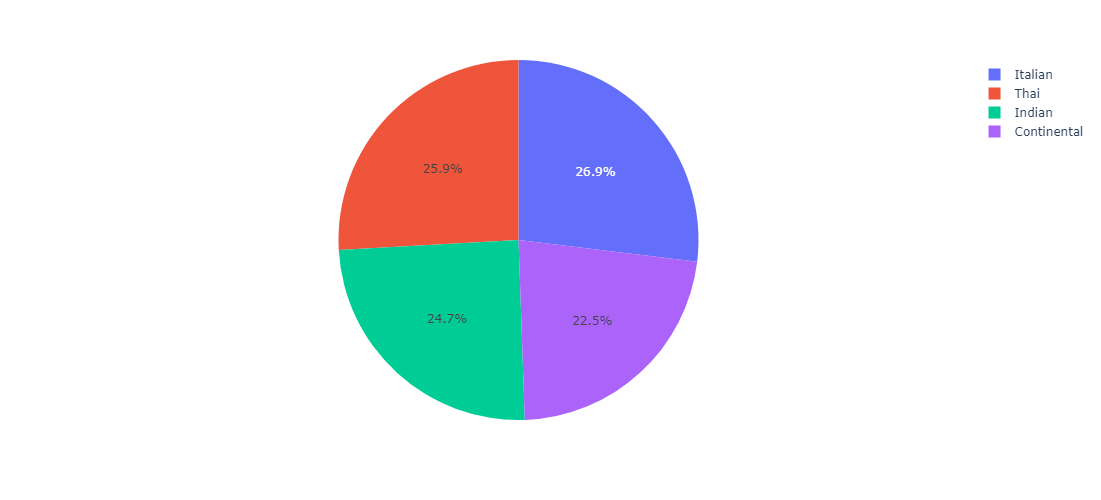

In [221]:
# Create a Pie chart for percentage of people like which cuisine
fig = px.pie(data , values = 'Percentage', names = 'cuisine', width=800, height=500)
pyoff.iplot(fig)

# CHeck where the Maximum Orders are coming from which centre type

In [222]:
# CHeck where the Maximum Orders are coming from which centre type
#del data_f
data_f = df['center_type'].value_counts(normalize = True) * 100
# Reset the Index
data_f = pd.DataFrame(data_f)

data_f = data_f.reset_index()

In [223]:
# Rename the column
data_f.rename(columns = {'proportion': 'Percentage'}, inplace = True) 
data_f.columns

Index(['center_type', 'Percentage'], dtype='object')

# Create a Pie chart for percentage of orders from which center type

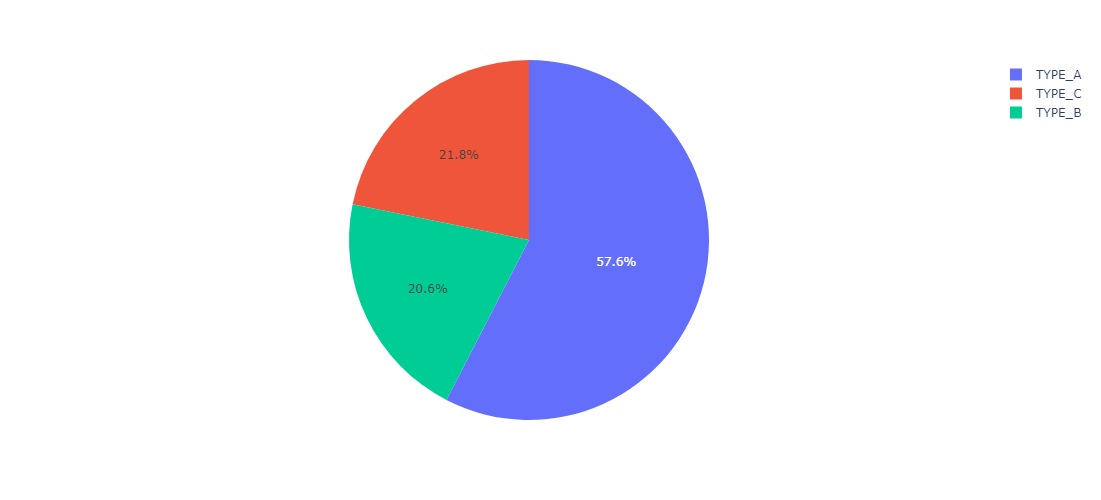

In [224]:
# Create a Pie chart for percentage of orders from which center type
fig = px.pie(data_f , values = 'Percentage', names = 'center_type', width=800, height=500)
pyoff.iplot(fig)

# Check the maximum orders placed for which category

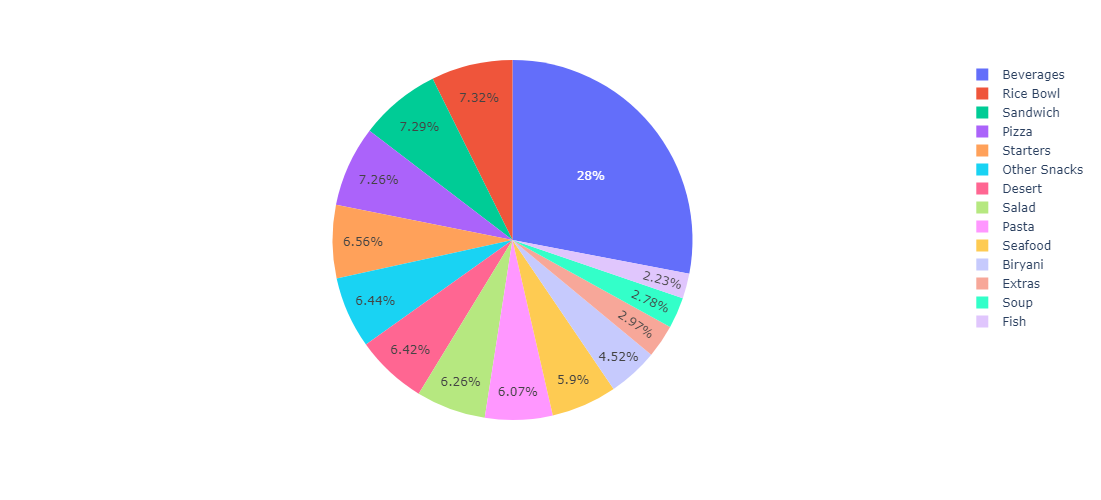

In [225]:
# Check the maximum orders placed for which category
df_cat = df['category'].value_counts(normalize = True) *  100
df_cat = df_cat.reset_index()
df_cat.rename(columns = {'proportion': 'Percentage'}, inplace = True) 
fig = px.pie(df_cat , values = 'Percentage', names = 'category', width=800, height=500)
pyoff.iplot(fig)

# Check for relationship between week and num of orders sold

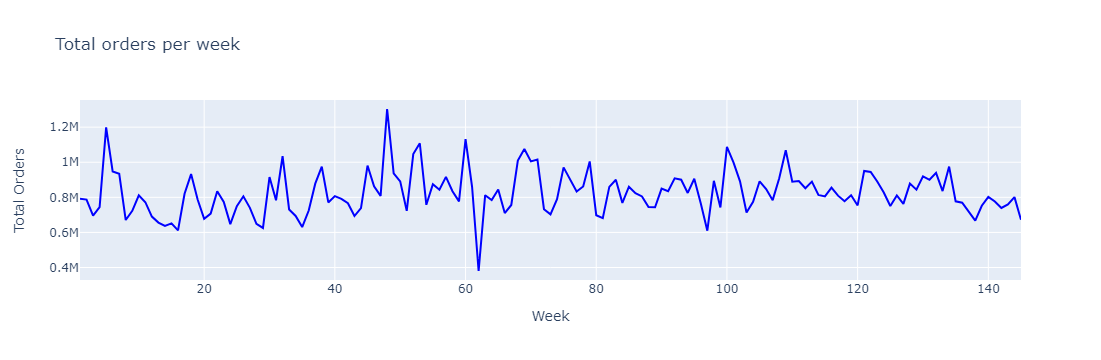

In [226]:
# Check for relationship between week and num of orders sold
data_ord = df.groupby(['week'])['num_orders'].sum()
data_ord = pd.DataFrame(data_ord)
plot_data = go.Scatter(x = data_ord.index, y = data_ord['num_orders'], name = 'Time Series for num_orders',
           marker = dict(color = 'Blue'))
plot_layout = go.Layout(title = 'Total orders per week', yaxis_title = 'Total Orders', xaxis_title = 'Week')
Fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(Fig)

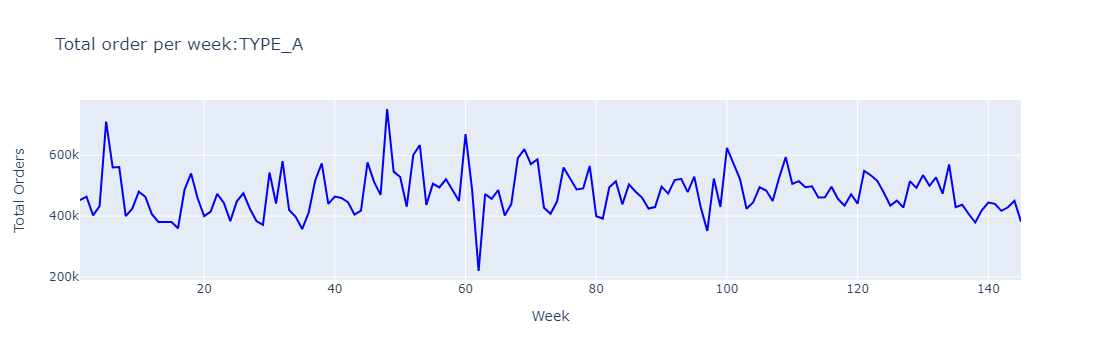

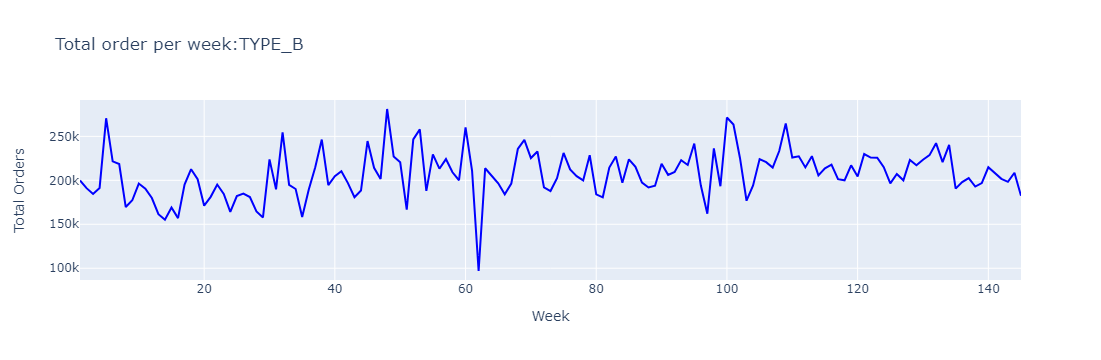

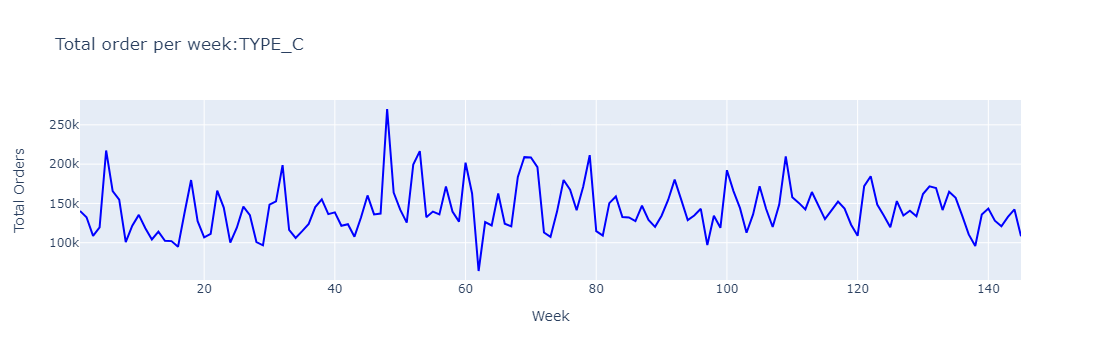

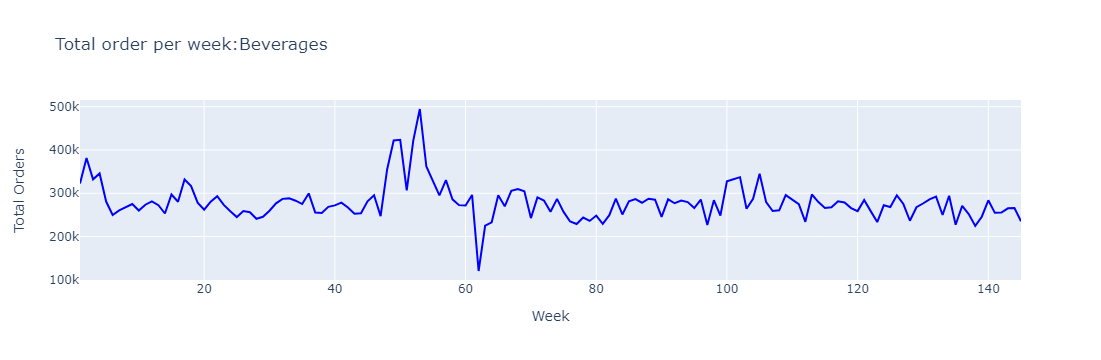

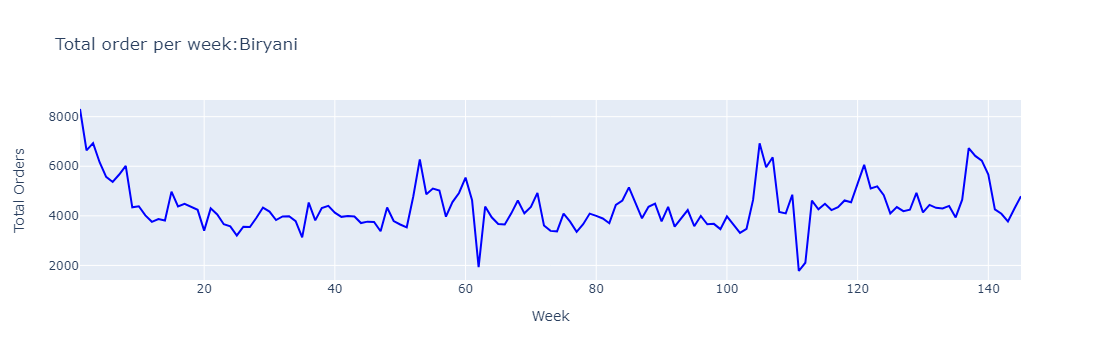

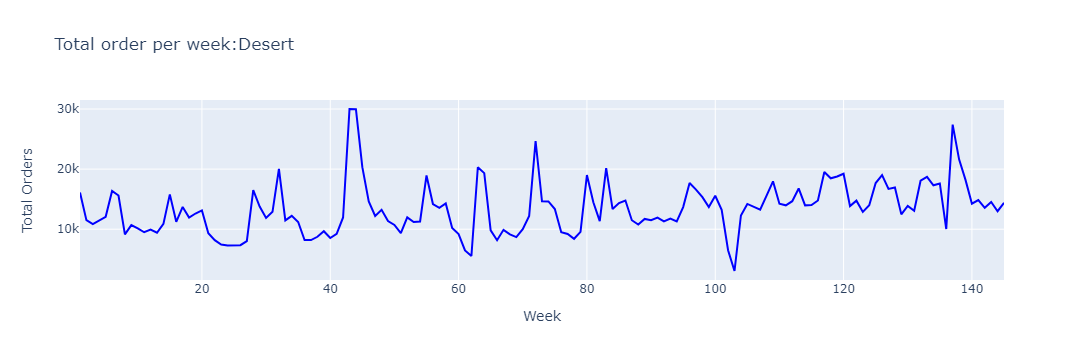

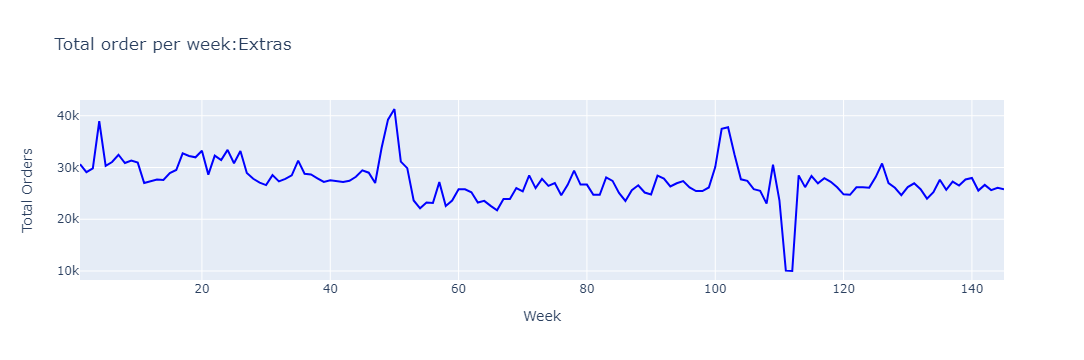

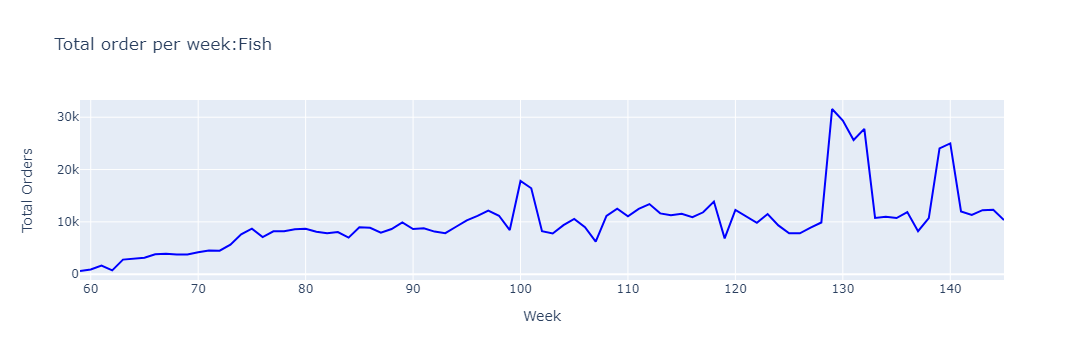

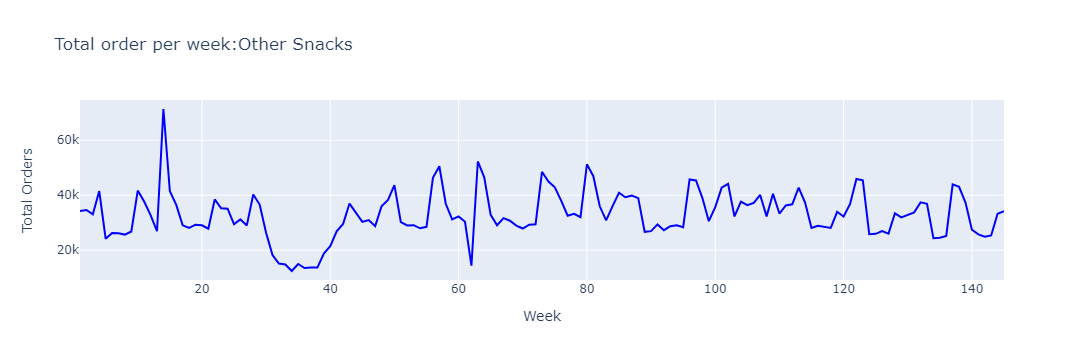

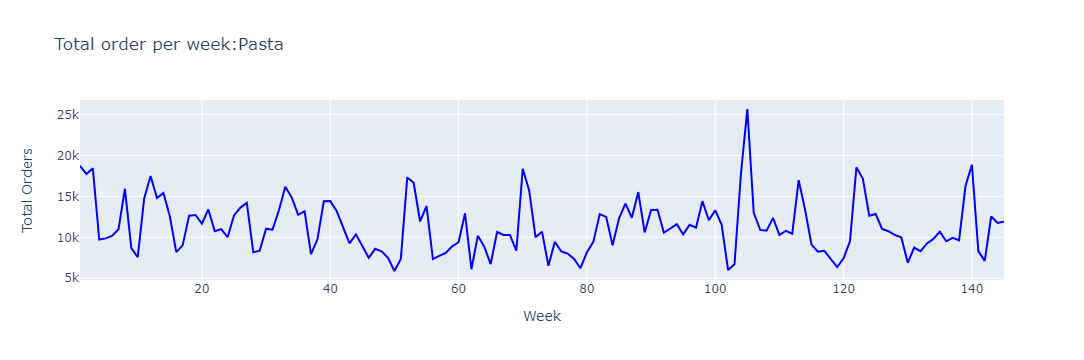

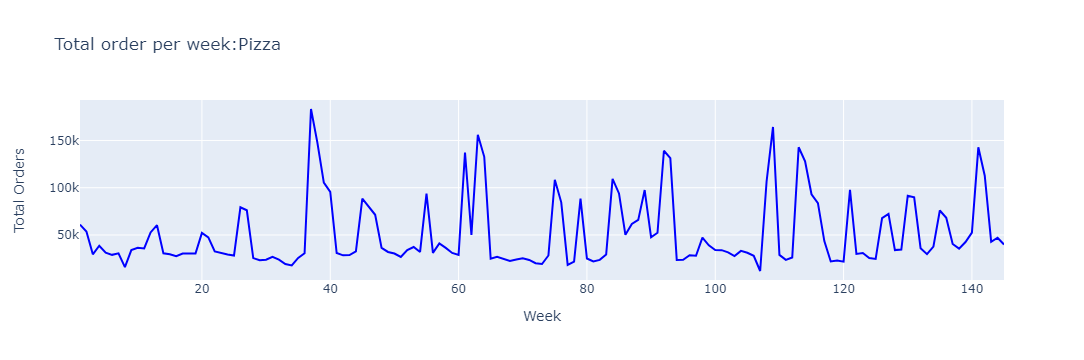

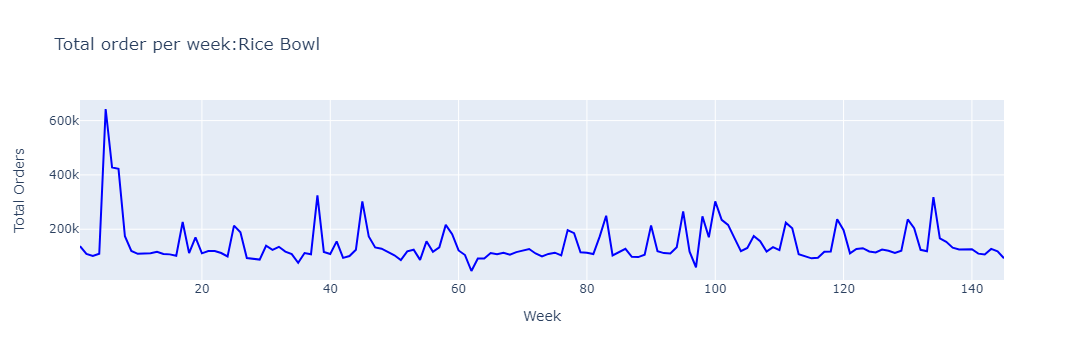

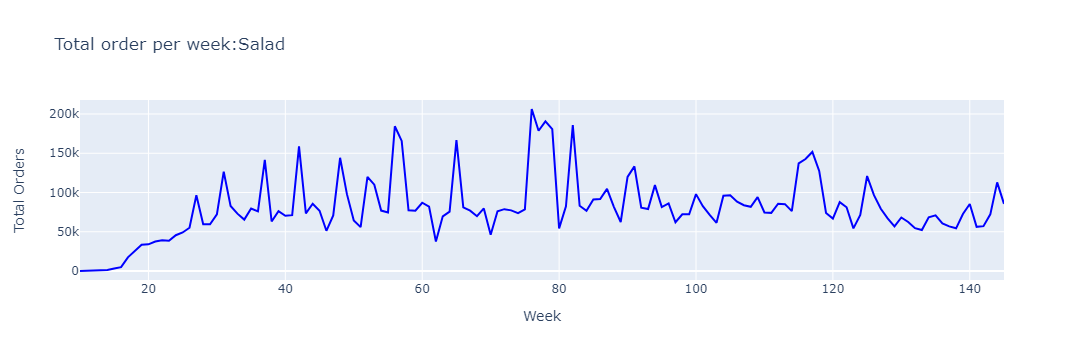

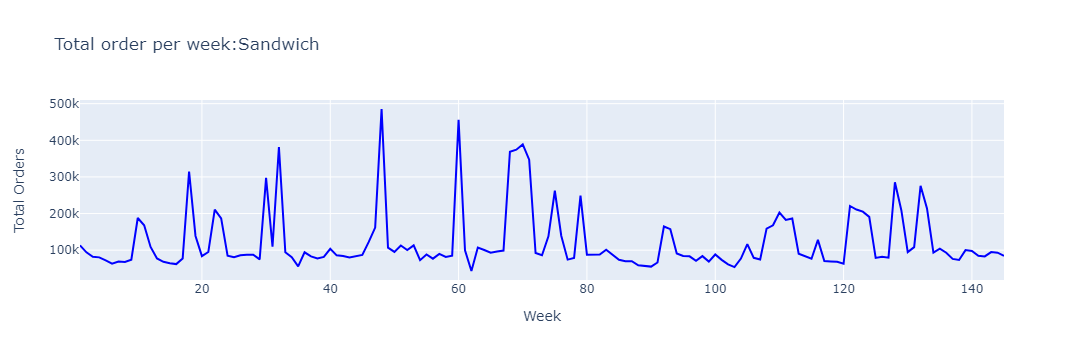

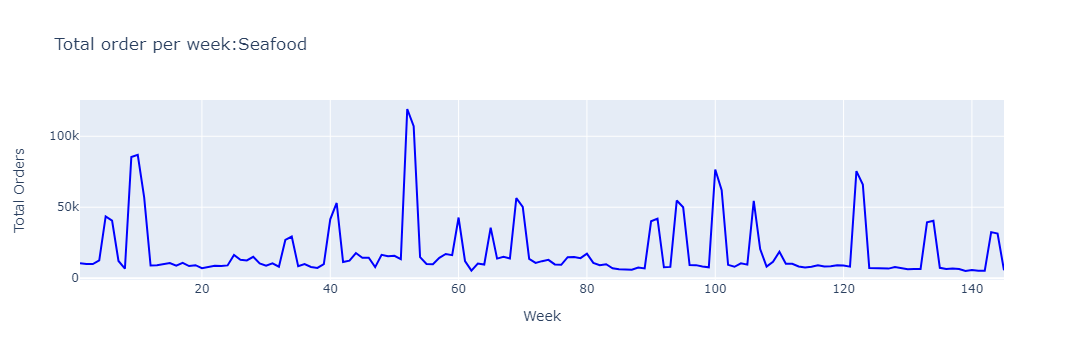

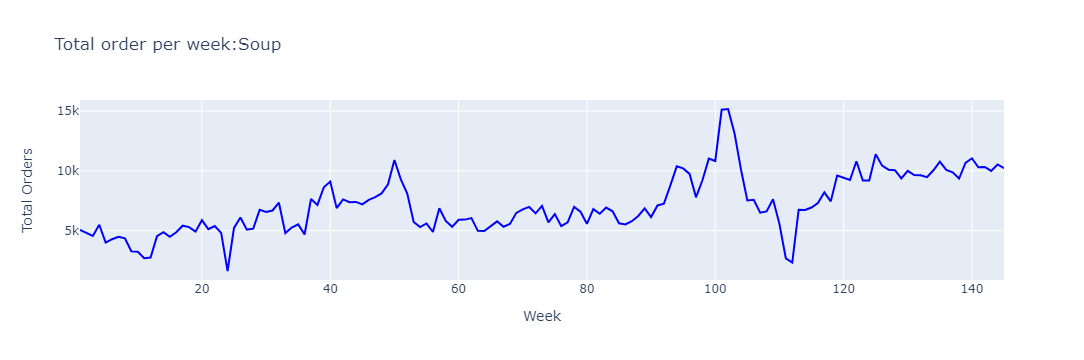

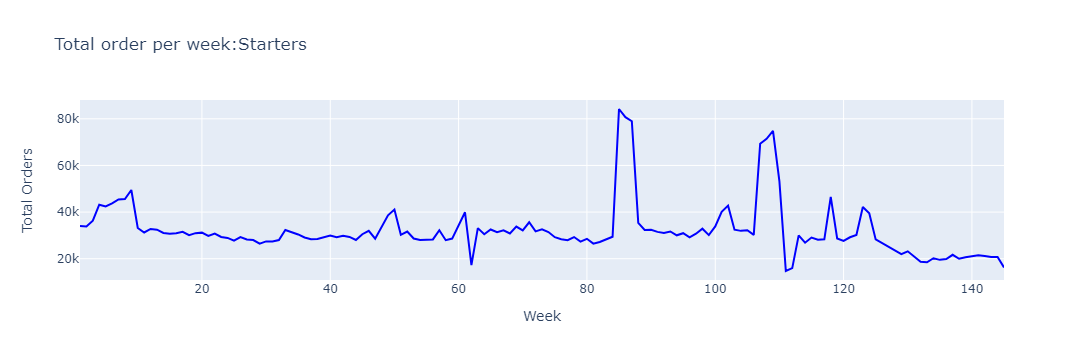

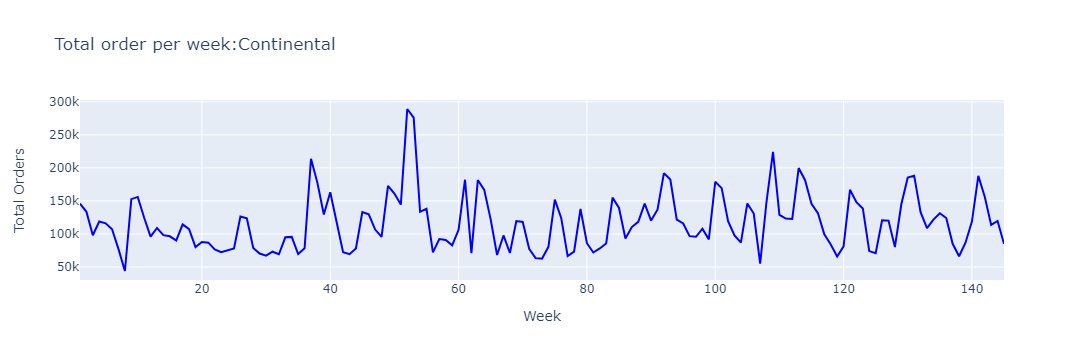

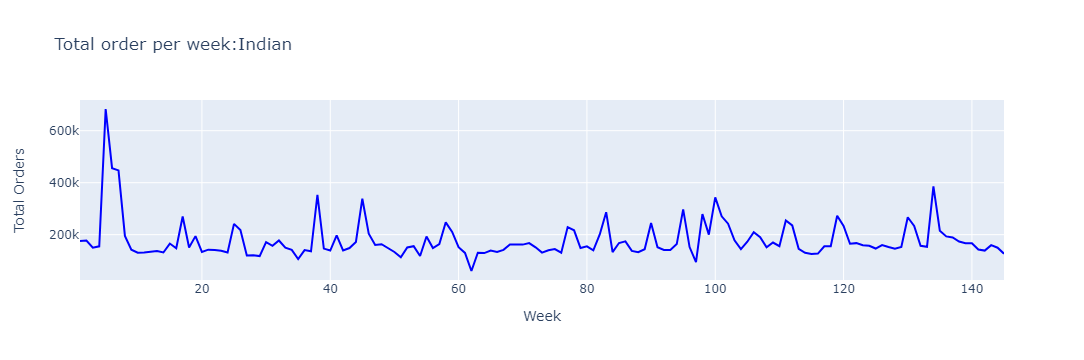

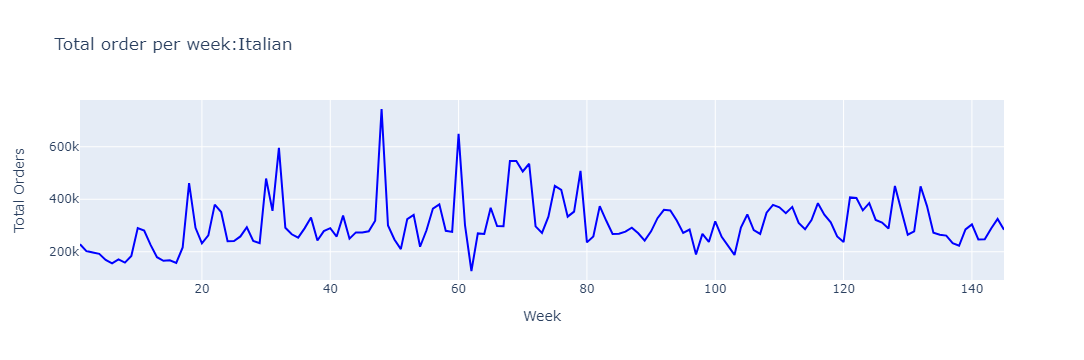

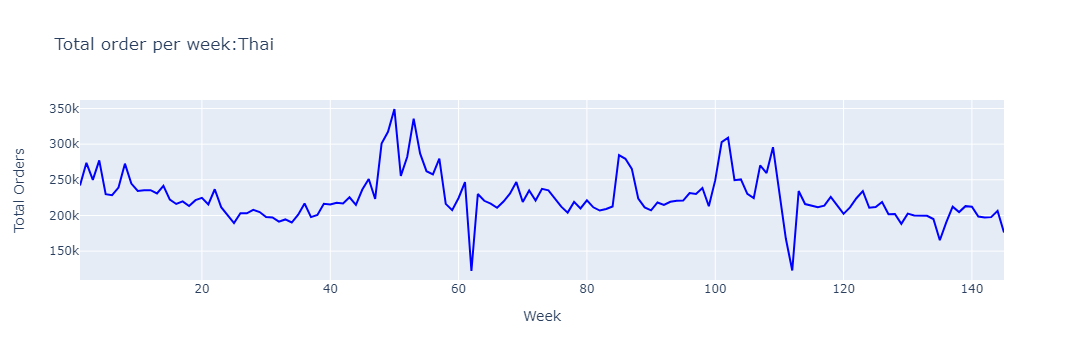

In [227]:
cat_var = ['center_type','category','cuisine']
for i in cat_var:
    grp = df.groupby([i])
    grp = pd.DataFrame(grp)
    lis  = grp[0]
    x = 0
    for j in lis:
        s  = list(j) 
        s_data = df[df[i] == s[0].strip(',')]
        data = pd.DataFrame(s_data)
        tot_orders = s_data.groupby(['week'])['num_orders'].sum()
        tot_orders = pd.DataFrame(tot_orders)
        data_plot  = [go.Scatter(x = tot_orders.index, y = tot_orders['num_orders'], name = 'Time series for num_orders for:' +s[0].strip(','), 
                                marker = dict(color = 'Blue'))]
        data_layout = go.Layout(title = 'Total order per week:' +s[0].strip(','), yaxis_title = 'Total Orders',xaxis_title = 'Week')
        fig = go.Figure(data = data_plot, layout = data_layout)
        x+=1
        pyoff.iplot(fig)




# Check the relationship between number of orders for particular cuisine from each location

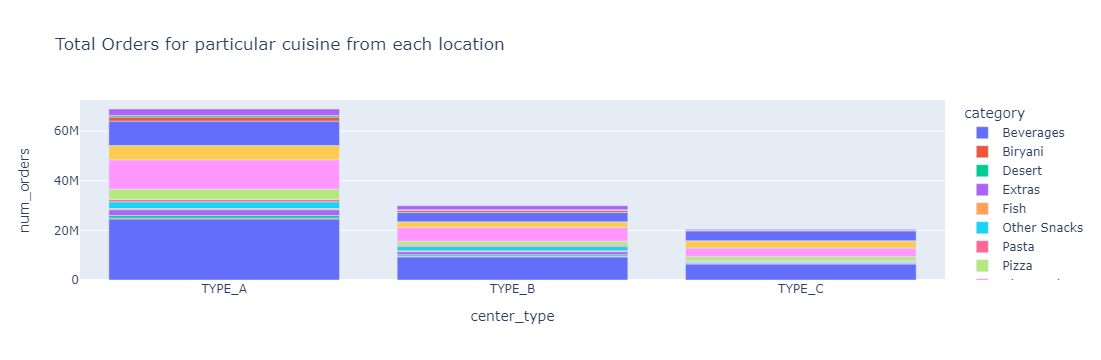

In [228]:
# Check the relationship between number of orders for particular cuisine from each location
grp = df.groupby(['category','center_type'])['num_orders'].sum()
grp = pd.DataFrame(grp) 
grp = grp.reset_index()
fig = px.bar(grp, x = 'center_type', y = 'num_orders', color = 'category', title = 'Total Orders for particular cuisine from each location')
pyoff.iplot(fig)

# Check the relationship between number of orders for particular cuisine from center location

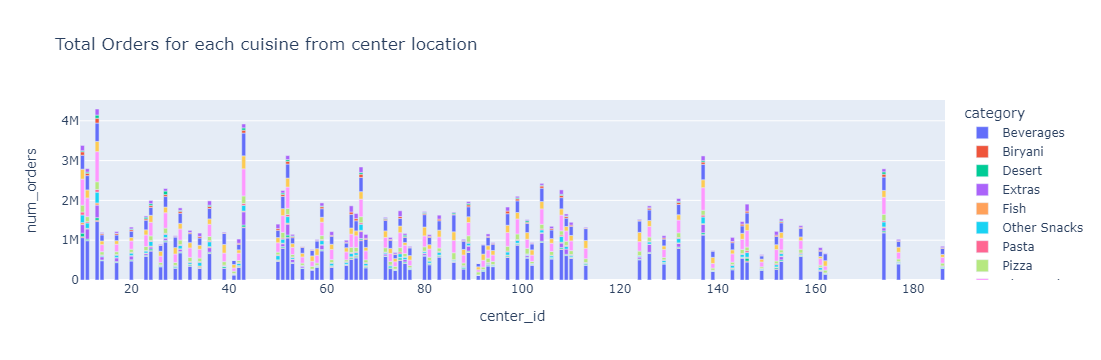

In [229]:
# Check the relationship between number of orders for particular cuisine from center location
grps = df.groupby(['category','center_id'])['num_orders'].sum()
grps = pd.DataFrame(grps) 
grps = grps.reset_index()
fig_1 = px.bar(grps, x = 'center_id', y = 'num_orders', color = 'category',title = 'Total Orders for each cuisine from center location')  
pyoff.iplot(fig_1)

# Check the relationship between number of orders for particular cuisine from center location

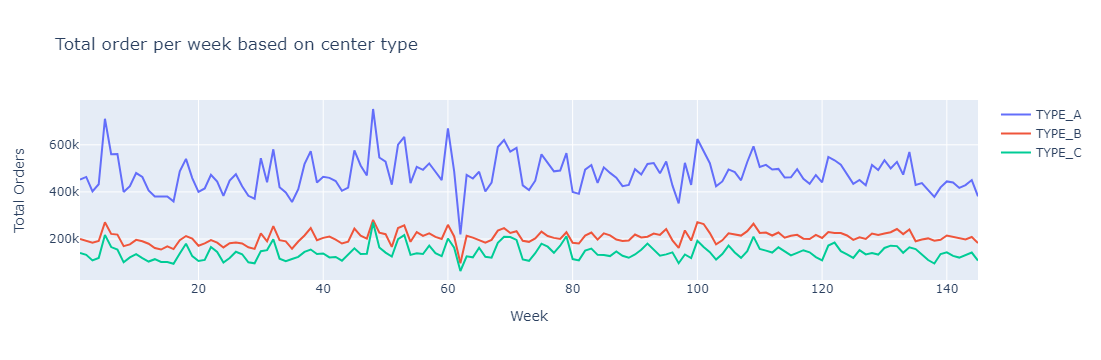

In [230]:
# Check the relationship between number of orders for particular cuisine from center location
cat_var = ['center_type']
for i in cat_var:
    grp = df.groupby([i])
    grp = pd.DataFrame(grp)
    lis  = grp[0]
    x = 0
    data_plot=[]
    for j in lis:
        s  = list(j) 
        s_data = df[df[i] == s[0].strip(',')]
        data = pd.DataFrame(s_data)
        tot_orders = s_data.groupby(['week'])['num_orders'].sum()
        tot_orders = pd.DataFrame(tot_orders)
        data_plot.append(go.Scatter(x = tot_orders.index, y = tot_orders['num_orders'],name = s[0].strip(','))) 
        x+=1
    data_layout = go.Layout(title = 'Total order per week based on center type', yaxis_title = 'Total Orders', xaxis_title = 'Week')
    fig = go.Figure(data = data_plot, layout = data_layout)
    pyoff.iplot(fig)


# CHeck if data have any correlation

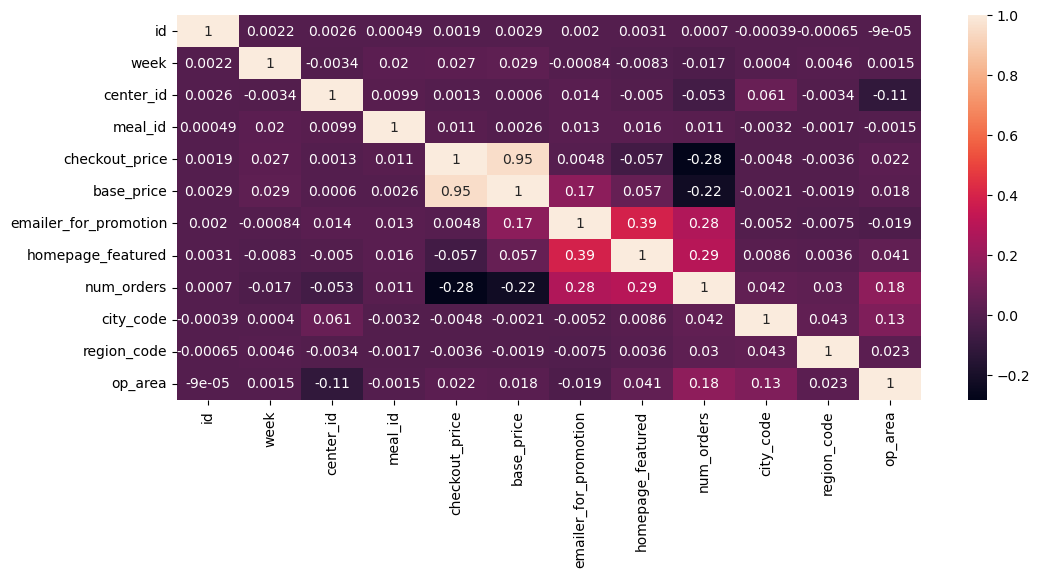

In [231]:
# CHeck if data have any correlation
df_copy = df
df_copy = df_copy.drop(columns = ['center_type','category','cuisine'])
cormat = df_copy.corr()
fig = plt.figure(figsize = (12,5))
sns.heatmap(cormat, annot = True)
plt.show()



# Inferences: Checkout_price, base_price show negative correlation while emailer_promotion and homepage_feature show positive correlation with num_orders.

In [232]:
grped_data = df.groupby(['category','cuisine'])['num_orders'].sum()
cat_cu_sc = grped_data.unstack().fillna(0)
cat_cu_sc

cuisine,Continental,Indian,Italian,Thai
category,,,,
Beverages,5943046.0,2345879.0,13953970.0,18237630.0
Biryani,0.0,631848.0,0.0,0.0
Desert,0.0,1940754.0,0.0,0.0
Extras,0.0,0.0,0.0,3984979.0
Fish,871959.0,0.0,0.0,0.0
Other Snacks,0.0,0.0,0.0,4766293.0
Pasta,0.0,0.0,1637744.0,0.0
Pizza,7383720.0,0.0,0.0,0.0
Rice Bowl,0.0,20874063.0,0.0,0.0


# Create a bar plot between category, cuisine and number of Orders

Text(0, 0.5, 'count')

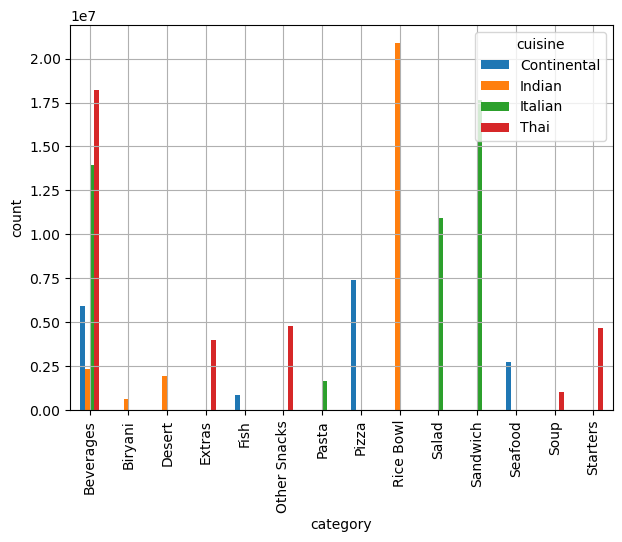

In [233]:
# Create a bar plot
ax = cat_cu_sc.plot(kind ='bar', figsize = (7,5),grid=True)
ax.set_ylabel('count')

# Graph between Number of Orders and Checkout Price

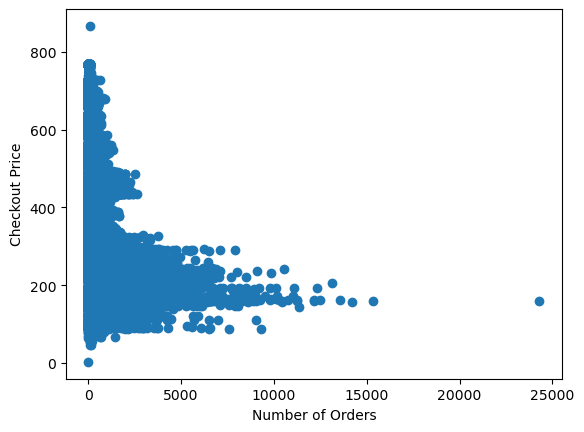

In [234]:
# Graph between Number of Orders and Checkout Price
plt.scatter(x = df['num_orders'], y = df['checkout_price'])
plt.xlabel('Number of Orders')
plt.ylabel('Checkout Price')
plt.show()

# Graph between Number of Orders and Base Price

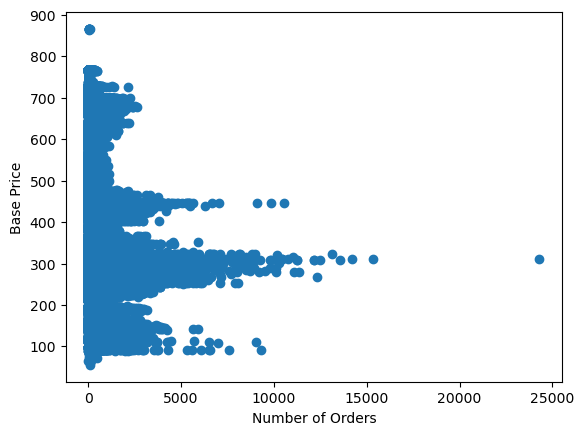

In [235]:
# Graph between Number of Orders and Base Price
plt.scatter(x = df['num_orders'], y = df['base_price'])
plt.xlabel('Number of Orders')
plt.ylabel('Base Price')
plt.show()

# Converting Categorical data to numerical for Model use

In [312]:
df_copy = df.copy()
X_copy = df[['center_type','cuisine']]
X_copy = pd.get_dummies(X_copy,drop_first=True)
df_copy.reset_index(drop = True,inplace = True)
X_copy.reset_index(drop = True,inplace = True)
df_copy = pd.concat([df_copy,X_copy],axis = 1 )


# Drop the Categorical columns

In [313]:
df_copy = df_copy.drop(columns = ['category','cuisine','center_type'])

In [314]:
# Seperate the Features 
X = df_copy.copy()
y = np.array(df_copy['num_orders'])

# Drop the y feature from X

In [315]:
X = X.drop(columns =['num_orders','id','center_type_TYPE_B','center_type_TYPE_C','cuisine_Indian','cuisine_Italian','cuisine_Thai'])

# Transform the data on comman scale to avoid outliers

In [316]:
X_scaled = preprocessing.RobustScaler().fit_transform(X)

# Split the data into training and test set

In [317]:
# Divide the data into train and test data
X_train, X_test,y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size = 0.30, random_state = 42)

In [318]:
# Instatiate the Xgb classifier
xgb = XGBRegressor(objective="reg:linear", random_state=42)

In [319]:
xgb.fit(X_train, y_train)

[13:28:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [320]:
y_pred = xgb.predict(X_test)

In [321]:
mse= metrics.mean_squared_error(y_test, y_pred)

In [322]:
print('Root Mean Squared Error for XGBoost:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error for XGBoost: 251.43164410450726


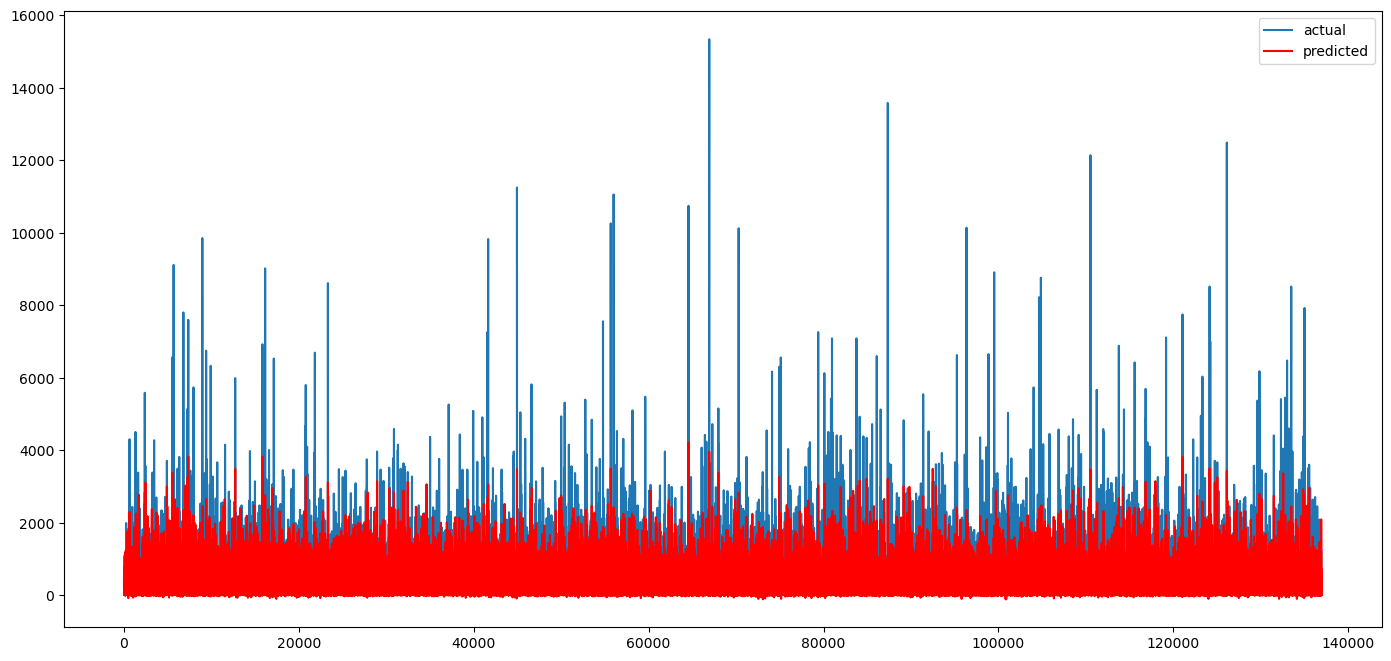

In [323]:
plt.figure(figsize=(17, 8))
plt.plot(y_test, label="actual")
plt.plot(y_pred, color='red', label="predicted")
plt.legend(loc='best')
plt.show()

# Plot the Feature Importance

<Axes: >

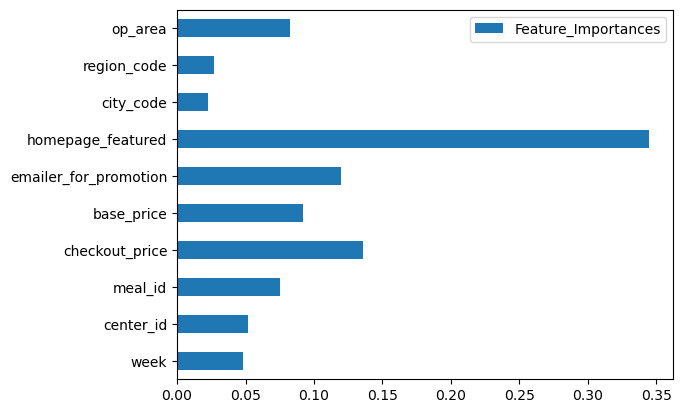

In [324]:
# plot the Feature Importance
feature_importances = pd.Series(xgb.feature_importances_)
index = X.columns
new_frame = pd.DataFrame({'Feature_Importances': list(feature_importances)}, index = index)
new_frame.plot.barh()

# Instatiate the Random Forest classifier

In [325]:
# Instatiate the Random Forest classifier
from sklearn import ensemble 
Rfr = ensemble.RandomForestRegressor(n_estimators = 100, random_state = 42) 

In [326]:
Rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [328]:
y_pred = Rfr.predict(X_test)

In [329]:
print('Root Mean Squared Error for Random Forest Regressor:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error for Random Forest Regressor: 154.8655605649132


[]

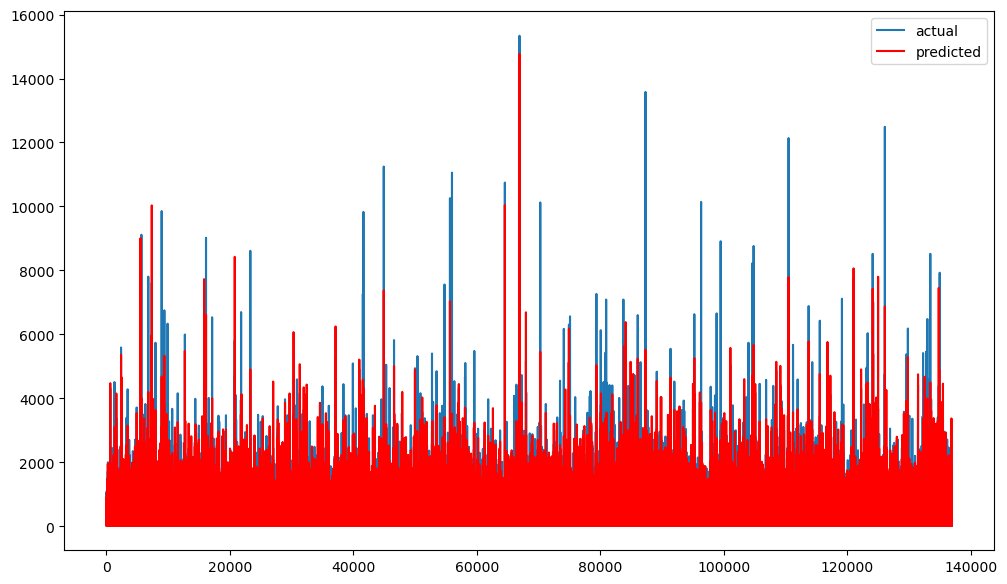

In [330]:
plt.figure(figsize= (12,7))
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted', color ='red')
plt.legend(loc ='best')
plt.plot()

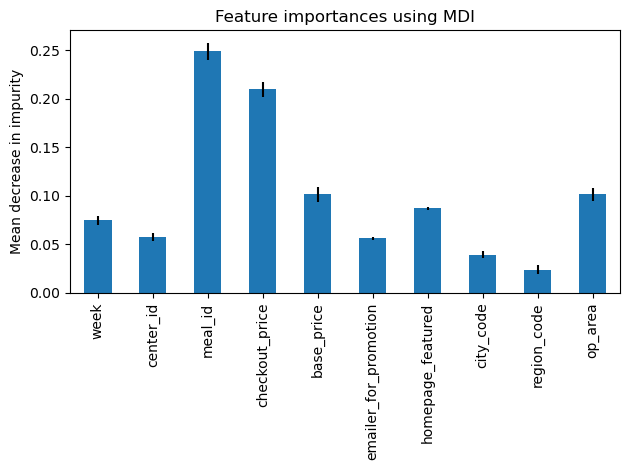

In [331]:
# plot the Feature Importance
importances = Rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Instatiate the Decision Tree classifier

In [332]:
# Instatiate the Decision Tree classifier
from sklearn import tree 
Dtr = tree.DecisionTreeRegressor(random_state = 42) 

In [333]:
Dtr.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [334]:
y_pred = Dtr.predict(X_test)

In [336]:
print('Root Mean Squared Error for Decision Tree:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error for Decision Tree: 222.1862603204343


# Implementing the Random Forest on required dataset

In [349]:
training = df.loc[:, ['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured','num_orders']] 

In [350]:
training

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1,55,1885,136.83,152.29,0,0,177
1,2,55,1885,135.83,152.29,0,0,323
2,3,55,1885,132.92,133.92,0,0,96
3,4,55,1885,135.86,134.86,0,0,163
4,5,55,1885,146.50,147.50,0,0,215
...,...,...,...,...,...,...,...,...
456543,141,61,2104,583.03,630.53,0,1,13
456544,142,61,2104,581.03,582.03,0,0,42
456545,143,61,2104,583.03,581.03,0,0,40
456546,144,61,2104,582.03,581.03,0,0,53


In [352]:
X_train = training.drop(['num_orders'], axis=1).values
y_train = training['num_orders'].values
X_test = df_test_data.drop(['id'],axis=1).values

In [353]:
from sklearn import ensemble 
Rfr = ensemble.RandomForestRegressor(n_estimators = 100, random_state = 42) 
Rfr.fit(X_train, y_train)
y_pred = Rfr.predict(X_test)
ypred = pd.DataFrame(y_pred)

In [354]:
ypred

,0
0,387.82
1,169.97
2,189.56
3,74.84
4,68.20
...,...
32568,56.68
32569,30.18
32570,417.08
32571,349.33


In [355]:
predictions = pd.merge(df_test_data,ypred,left_index = True, right_index = True,how ='inner')

In [356]:
predictions

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,0
0,1028232,146,55,1885,158.11,159.11,0,0,387.82
1,1127204,146,55,1993,160.11,159.11,0,0,169.97
2,1212707,146,55,2539,157.14,159.14,0,0,189.56
3,1082698,146,55,2631,162.02,162.02,0,0,74.84
4,1400926,146,55,1248,163.93,163.93,0,0,68.20
...,...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0,56.68
32569,1039516,155,61,2304,483.09,483.09,0,0,30.18
32570,1158107,155,61,2664,322.07,323.07,0,0,417.08
32571,1444235,155,61,2569,322.07,323.07,0,0,349.33


In [357]:
predictions['num_orders'] = predictions[0]

In [358]:
predictions = predictions.drop(columns =[0])

In [359]:
ts_ord_pred = predictions.groupby(['week'])['num_orders'].sum()
ts_ord_pred = pd.DataFrame(ts_ord_pred)

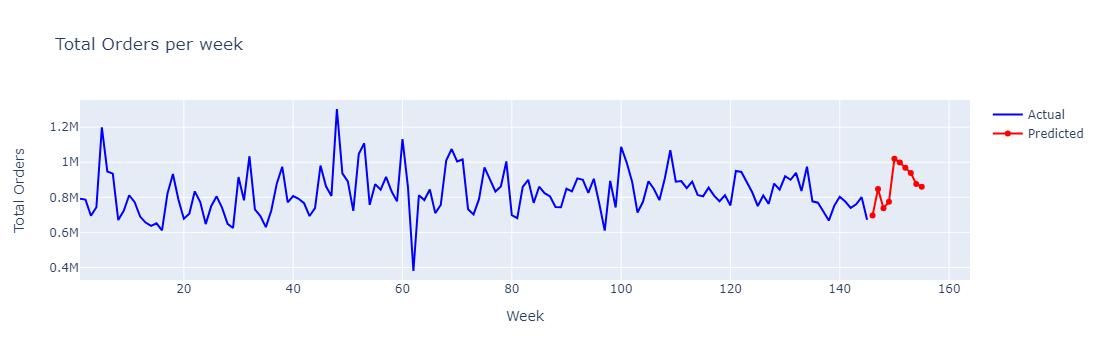

In [360]:
plot_data = [go.Scatter(x=data_ord.index, y = data_ord['num_orders'],
                        name = 'Actual',
                        marker = dict(color = 'Blue')),
             go.Scatter(x = ts_ord_pred.index, y = ts_ord_pred['num_orders'],
                        name = 'Predicted',
                        marker = dict(color = 'Red'))
                        ]
plot_layout = go.Layout(title = 'Total Orders per week',
                        yaxis_title = 'Total Orders',
                        xaxis_title = 'Week')

fig = go.Figure(data = plot_data,layout =plot_layout)
pyoff.iplot(fig)